<a href="https://colab.research.google.com/github/maykends/Processamento-de-Linguagem-Natural/blob/master/Twitter_Redes_Neurais_Convolucionais_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificações de Sentimento do Twitter usando CNN



**Classificação de sentimentos do Twitter.**

Neste notebook iremos treinar uma Rede Neural convolutiva com o intuito de classificar sentimentos do *Twitter em uma CNN*.

- **Aluno(a):** Mayke Kend Gomes Delgado.
- **Prof.** Jones Granatier
- **Curso:** Pós-Graduação em Ciência de Dados.
- **Disciplina** **169025** - Processamento de Linguagem Natural
- **Matrícula:** 1691690020

# Etapa 1: Importação das bibliotecas

In [ ]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
from google.colab import drive
import zipfile
import seaborn as sns
import spacy as sp
import string
import random
import matplotlib.pyplot as plt

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

'2.4.1'

In [ ]:
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Etapa 2: Pré-processamento dos dados

## Carregamento dos arquivos

In [ ]:
train_data = pd.read_csv('/content/Train50.csv',
                        delimiter=';',
                        #header=None,
                        #names=cols,
                        engine="python",
                        encoding="latin1"
)# leitura

In [ ]:
train_data.shape

(50000, 5)

In [ ]:
train_data.head()

,id,tweet_text,tweet_date,sentiment,query_used
0,1050785521201541121,@Laranjito76 A pessoa certa para isso seria o ...,Fri Oct 12 16:29:25 +0000 2018,1,:)
1,1050785431955140608,"@behin_d_curtain Para mim, Ã© precisamente o c...",Fri Oct 12 16:29:04 +0000 2018,1,:)
2,1050785401248645120,Vou fazer um video hoje... estou pensando em f...,Fri Oct 12 16:28:56 +0000 2018,1,:)
3,1050785370982547461,"aaaaaaaa amei tanto essas polaroids, nem sei e...",Fri Oct 12 16:28:49 +0000 2018,1,:)
4,1050785368902131713,Valoriza o coraÃ§Ã£o do menininho que vc tem. ...,Fri Oct 12 16:28:49 +0000 2018,1,:)


In [ ]:
train_data.tail()

,id,tweet_text,tweet_date,sentiment,query_used
49995,1046762827053232128,:( Ã© tÃ£o lindo que dÃ³i https://t.co/GqnpgyWWxB,Mon Oct 01 14:04:40 +0000 2018,0,:(
49996,1046762813362966529,"@veraluciarj Pois Ã©.. tenho problema c/ ""cois...",Mon Oct 01 14:04:37 +0000 2018,0,:(
49997,1046762806392082432,eu te amo tanto minja vidinha meu bem mais pre...,Mon Oct 01 14:04:35 +0000 2018,0,:(
49998,1046762752071618560,@itsLary @jessboluda Pfvor :(,Mon Oct 01 14:04:22 +0000 2018,0,:(
49999,1046762735340584962,@Renk_lol Passa ano Entra ano Eu nao desisto d...,Mon Oct 01 14:04:18 +0000 2018,0,:(


In [ ]:
train_data.sentiment.unique()

array([1, 0])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


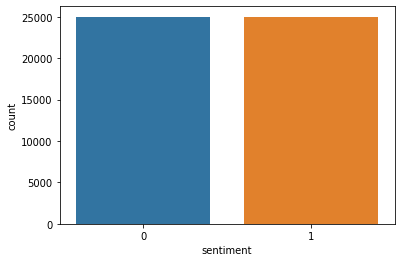

In [ ]:
sns.countplot(train_data.sentiment);

In [ ]:
test_data = pd.read_csv('/content/Test.csv',
                        delimiter=';',
                        #header=None,
                        #names=cols,
                        engine="python",
                        encoding="latin1"
) # carregando a base_teste

In [ ]:
test_data.head() # lendo os primeiros registros

,id,tweet_text,tweet_date,sentiment,query_used
0,1029536486021099522,@Gazo1a Nossa! Muito obrigada :),Wed Aug 15 01:13:20 +0000 2018,1,:)
1,1029536496368406528,@BerzGamer vai pa puta que te pariu :),Wed Aug 15 01:13:23 +0000 2018,1,:)
2,1029536531655131137,QUER MAIS DESCONTOS? (14/08) â­â­â­â­â­ ð...,Wed Aug 15 01:13:31 +0000 2018,1,:)
3,1029536560117678081,"EU VOU PEGAR VCS, ME AJUDEM GALERA, PELO AMOR ...",Wed Aug 15 01:13:38 +0000 2018,1,:)
4,1029536605852377088,EstÃ¡vamos em casa do ZÃ© e eu estava a morrer...,Wed Aug 15 01:13:49 +0000 2018,1,:)


In [ ]:
test_data.shape

(5000, 5)

In [ ]:
test_data.sentiment.unique()

array([1, 0])

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


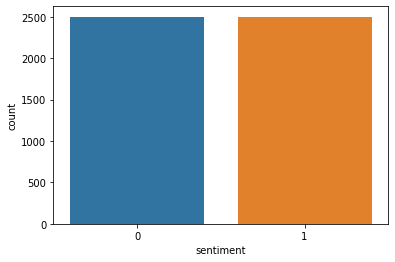

In [ ]:
sns.countplot(test_data.sentiment);

## Pré-processamento

### Limpeza

In [ ]:
data = train_data

In [ ]:
data.drop(['id', 'tweet_date', 'query_used'], axis = 1, inplace=True) # removendo as colunas irrelevantes

In [ ]:
data.head()

,tweet_text,sentiment
0,@Laranjito76 A pessoa certa para isso seria o ...,1
1,"@behin_d_curtain Para mim, Ã© precisamente o c...",1
2,Vou fazer um video hoje... estou pensando em f...,1
3,"aaaaaaaa amei tanto essas polaroids, nem sei e...",1
4,Valoriza o coraÃ§Ã£o do menininho que vc tem. ...,1


In [ ]:
X = data.iloc[:, 0].values # retona apenas os textos

In [ ]:
X  # lendo os textos

array(['@Laranjito76 A pessoa certa para isso seria o vale e azevedo :)',
       '@behin_d_curtain Para mim, Ã© precisamente o contrÃ¡rio :) Vem a chuva e vem a boa disposiÃ§Ã£o :)',
       'Vou fazer um video hoje... estou pensando em falar um pouco sobre o novo meta do CSGO e sobre a pagina https://t.co/5RjhKnj0oh Alguem tem uma sugestao? Queria falar sobre algo do cenario nacional :D',
       ...,
       'eu te amo tanto minja vidinha meu bem mais precioso me desculpa ser uma pÃ©ssima utted mas eu te amo mais que tudo nem palavras Ã© capaz de explicar o tamanho do amor que sinto por ti :(((( https://t.co/4ND7F203et',
       '@itsLary @jessboluda Pfvor :(',
       '@Renk_lol Passa ano Entra ano Eu nao desisto do NA :('],
      dtype=object)

In [ ]:
X.shape

(50000,)

In [ ]:
type(X)

numpy.ndarray

In [ ]:
y = data.iloc[:, 1].values # retorna sentimentos
y

array([1, 1, 1, ..., 0, 0, 0])

In [ ]:
from sklearn.model_selection import train_test_split
X, _, y, _ = train_test_split(X, y, test_size = 0.93, stratify = y) # vamos dividir a base de dados entre treinamento e teste, são 93% para testar

In [ ]:
X.shape # textos para treinar

(3500,)

In [ ]:
y.shape

(3500,)

In [ ]:
unique, counts = np.unique(y, return_counts=True)
unique, counts # realiza as contagens, temos 1750 palavras únicas nos textos

(array([0, 1]), array([1750, 1750]))

In [ ]:
def clean_tweets(tweet): # realizando pré-processamento nos dados
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet) # remoção de usuário
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet) # remoção de links
  tweet = re.sub(r"[^a-zA-Z.!?]", ' ', tweet) # remoção de espaços em ranco
  tweet = re.sub(r" +", ' ', tweet)
  return tweet

In [ ]:
# realizando um teste
text = "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  2 You shoulda got David Carr of Third Day to do it. ;D"

In [ ]:
text = clean_tweets(text)
text # resultado do teste

' Awww that s a bummer. You shoulda got David Carr of Third Day to do it. D'

In [ ]:
nlp = sp.load('en')
nlp # carregar um modelo do spacy em um modelo em inglês

In [ ]:
stop_words = sp.lang.en.STOP_WORDS # Usaremos stop_words para realizarmos um pré-processamento nos dados

In [ ]:
print(stop_words) # identificando as palavras irrelevantes

{'thence', 'call', 'between', 'us', 'neither', 'again', 'she', 'when', 'meanwhile', 'his', 'forty', '‘ll', 'me', 'has', 'mostly', 'around', 'enough', 'indeed', 'sixty', 'everywhere', 'once', 'than', 'ours', 'alone', 'hereafter', 'quite', 'onto', 'until', 'regarding', 'many', 'done', 'somehow', 'make', 'nevertheless', 'move', 'though', 'therefore', 'various', 'since', 'while', 'after', 'its', 'first', 'which', 'are', "'d", 'few', 'both', 'show', 'before', 'even', "'re", 'something', 'whose', 'eight', 'to', 'by', 'eleven', 'part', 'either', 'becoming', 'moreover', 'seems', 'about', 'top', 'thereupon', 'a', 'two', '‘m', 'latterly', 'in', 'go', 'an', 'beforehand', 'just', 'where', 'everyone', 'take', 'formerly', '‘re', 'one', 'why', 'himself', 'several', 'nor', 'along', 'through', 'our', 'made', 'never', 'now', 'their', 'four', 'against', 'thus', 'say', 'sometimes', 'name', 'someone', 'often', 'too', 'least', 'wherein', 'into', 'former', 'very', 'towards', 'beyond', 'we', 'if', '‘s', 'and'

In [ ]:
len(stop_words) # quantidade de stop_words em inglês, bem inferior a nossa base de dados em português

326

In [ ]:
string.punctuation # visualizando as pontuações

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
def clean_tweets2(tweet):
  tweet = tweet.lower()
  document = nlp(tweet)

  words = []
  for token in document:
    words.append(token.text)

  words = [word for word in words if word not in stop_words and word not in string.punctuation]
  words = ' '.join([str(element) for element in words])

  return words # função para realizar o pré-processamento

In [ ]:
# Awww that's a bummer. You shoulda got David Carr of Third Day to do it. D"

In [ ]:
text2 = clean_tweets2(text)
text2 # resultado de mais um teste em inglês

'  awww s bummer shoulda got david carr day d'

In [ ]:
data_clean = [clean_tweets2(clean_tweets(tweet)) for tweet in X] # dados limpos, demora um pouco em relação aos textos

In [ ]:
for _ in range(10):  # selecionando os textos aleatoricamente com o intuito de retonar textos em randons
  print(data_clean[random.randint(0, len(data_clean) - 1)])

  espero muito que minha m e sa hosp l pra eu ter pique de ir
  t frio demais m hug
  almeida isso depende de o quanto d o problema que voc est resolvendo eu j entreguei mvps que deixaram o cliente t o feliz quanto esse cara skate
  qual eh o teu signo sou de fome com ascend ncia em sonos
  s resta chorar
qria conseguir tirar notif de caixa postal meu cel
que cara escroto se t bom pra ele ok o resto f
  n o foi manu d avila ahhhh e parab ns
  olhe pra voc e pense se voc se encaixa nisso esteri tipos n o dizem nada sobre ningu m apenas s o esteri tipos
  acho que gente ainda t bestializado tudo se anunciou h mt tempo mas segue sendo surreal


In [ ]:
data_labels = y

In [ ]:
data_labels[data_labels == 4] = 1

In [ ]:
data_labels

array([0, 1, 0, ..., 0, 0, 0])

In [ ]:
np.unique(data_labels)

array([0, 1])

### Tokenização

In [ ]:
2**16

65536

In [ ]:
import math
math.pow(2, 16)

65536.0

In [ ]:
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16)

In [ ]:
tokenizer.vocab_size # foi gerado 8950 palavras únicas

8691

In [ ]:
print(tokenizer.subwords)

['o_', '  ', 'que_', 'de_', 'e_', 'eu_', 'n_', 's_', 'pra_', 'mas_', 'com_', 'um_', 't_', 'se_', 'meu_', 'na_', 'm_', 'da_', 'uma_', 'mais_', 'por_', 'em_', 'q_', 'minha_', 'muito_', 'voc_', 'vou_', 'tem_', 'para_', 'ser_', 'isso_', 'vai_', 'os_', 'j_', 'dia_', 'd_', 'vc_', 'ele_', ' ... ', 'te_', 'queria_', 'como_', 'bem_', 'ter_', 'gente_', 'bom_', 'pq_', 'foi_', 'p_', 'tenho_', 'nem_', 'tudo_', 'esse_', 'essa_', 'ou_', 'v_', 'mesmo_', 'est_', 'ainda_', 'aqui_', 'ver_', 'ela_', 'sim_', 'quero_', 'nao_', 'quando_', 'amo_', 'quem_', 'sou_', 'agora_', 'fazer_', 'acho_', 'triste_', 'pelo_', 'hoje_', 'estou_', 'era_', 'ta_', 'tamb_', 'sem_', 'ir_', 'pode_', 'seu_', 'ai_', 'sempre_', 'ficar_', 'boa_', 'feliz_', 'meus_', 'es_', 'tu_', 'dos_', 'ao_', 'l_', 'ent_', 'das_', ' ...', 'tava_', 'nada_', 'melhor_', 'tanto_', 'rio_', 'sei_', 'mt_', 'c_', 'b_', 'vamos_', 'todos_', 'pessoas_', 'assim_', 'todo_', 'sua_', 'ncia_', 'faz_', 'vel_', 'algu_', 'vcs_', 'nunca_', 'menos_', 'estar_', 'eles_', '

In [ ]:
ids = tokenizer.encode('happy')
ids

[8539, 8091, 8547, 8556]

In [ ]:
text = tokenizer.decode(ids)
text

'happy'

In [ ]:
tokenizer.decode([105]), tokenizer.decode([2257]), tokenizer.decode([3119])

('c ', 'morais ', 'vidas ')

In [ ]:
data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

In [ ]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[79, 17, 27, 14, 810, 1, 1789, 125, 1846, 21, 8543]
[2, 5761, 502, 1, 7134, 8408, 1448]
[967, 7, 1, 711, 1598, 10, 711, 2154, 8299, 5, 5695, 4, 4993, 3, 85, 3681]
[2184, 6, 20, 3496, 39, 1784]
[2, 4109, 87, 553]
[5, 16, 189, 3, 6800, 1762, 1, 132, 16, 1857, 158, 13, 1, 88, 5, 7233, 16, 3091]
[2, 27, 6982, 22, 531]
[2, 40, 67, 15, 282]
[6, 2518, 52, 9, 330, 6291, 1, 4, 2744]
[65, 3194]


### Padding

In [ ]:
max_len = max([len(sentence) for sentence in data_inputs])
max_len # setença com o meior lista de tokens

# O padding gera os mesmos tamanhos entre as setenças

60

In [ ]:
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value = 0,
                                                            padding = 'post',
                                                            maxlen=max_len)

In [ ]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[   2 5835  348 8169   27  120 3350    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
[ 340  374    5 3170 2625   58    1   15 1473    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
[   2 3938   78  324  583    7    1   82  143 4709  618  504    3  394
 1253 6206 1876 1309    7    1 6864  258  688  219 8535    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
[   2 3755    6  293  176   31 5490  523  577   10  104 1874    0    0
    0    0 

### Divisão da base de dados em treinamento e teste



In [ ]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs,
                                                                        data_labels,
                                                                        test_size=0.3,
                                                                        stratify = data_labels)

In [ ]:
train_inputs[0]

array([ 393,  108,   33,   89, 6185,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0], dtype=int32)

In [ ]:
train_inputs.shape

(2450, 60)

In [ ]:
train_labels.shape # vamos testar 2450 registros

(2450,)

In [ ]:
test_inputs.shape

(1050, 60)

In [ ]:
test_labels.shape # vamos testar 1050 registros

(1050,)

In [ ]:
# Salvando arquivos
# train_inputs, test_inputs, train_labels, test_labels

import pickle
with open('save.pkl', 'wb') as f:
  pickle.dump([train_inputs, test_inputs, train_labels, test_labels], f)


# Etapa 3: Construção do modelo

In [ ]:
class DCNN(tf.keras.Model):

  def __init__(self,
               vocab_size,
               emb_dim=128,
               nb_filters=50,
               ffn_units=512,
               nb_classes=2,
               dropout_rate=0.1,
               training=True,
               name="dcnn"):
    super(DCNN, self).__init__(name=name)

    self.embedding = layers.Embedding(vocab_size, emb_dim)

    # Conv2D
    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')

    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')

    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')

    self.pool = layers.GlobalMaxPool1D()

    self.dense_1 = layers.Dense(units = ffn_units, activation = 'relu')
    self.dropout = layers.Dropout(rate = dropout_rate)
    if nb_classes == 2:
      self.last_dense = layers.Dense(units = 1, activation = 'sigmoid')
    else:
      self.last_dense = layers.Dense(units = nb_classes, activation = 'softmax')

  def call(self, inputs, training):
    x = self.embedding(inputs)
    x_1 = self.bigram(x)
    x_1 = self.pool(x_1)
    x_2 = self.trigram(x)
    x_2 = self.pool(x_2)
    x_3 = self.fourgram(x)
    x_3 = self.pool(x_3)

    merged = tf.concat([x_1, x_2, x_3], axis = -1) # (batch_size, 3 * nb_filters)
    merged = self.dense_1(merged)
    merged = self.dropout(merged, training)
    output = self.last_dense(merged)

    return output

# Etapa 4: Treinamento

## Configuração dos parâmetros

In [ ]:
vocab_size = tokenizer.vocab_size
vocab_size

8691

In [ ]:
emb_dim = 200
nb_filters = 100
ffn_units = 256
batch_size = 64
nb_classes = len(set(train_labels))
nb_classes

2

In [ ]:
dropout_rate = 0.2
nb_epochs = 10

## Treinamento

In [ ]:
Dcnn = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters,
            ffn_units=ffn_units, nb_classes=nb_classes, dropout_rate=dropout_rate)

In [ ]:
if nb_classes == 2:
  Dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
  Dcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
checkpoint_path = "./"
ckpt = tf.train.Checkpoint(Dcnn=Dcnn)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored')

In [ ]:
history = Dcnn.fit(train_inputs, train_labels,
                   batch_size = batch_size,
                   epochs = nb_epochs,
                   verbose = 1,
                   validation_split = 0.10)
ckpt_manager.save()

Epoch 1/10
35/35 [==============================] - 35s 37ms/step - loss: 0.6901 - accuracy: 0.5359 - val_loss: 0.6493 - val_accuracy: 0.6694
Epoch 2/10
35/35 [==============================] - 1s 20ms/step - loss: 0.5372 - accuracy: 0.8200 - val_loss: 0.5740 - val_accuracy: 0.6816
Epoch 3/10
35/35 [==============================] - 1s 20ms/step - loss: 0.1718 - accuracy: 0.9583 - val_loss: 0.6927 - val_accuracy: 0.6857
Epoch 4/10
35/35 [==============================] - 1s 21ms/step - loss: 0.0340 - accuracy: 0.9914 - val_loss: 0.8760 - val_accuracy: 0.6898
Epoch 5/10
35/35 [==============================] - 1s 21ms/step - loss: 0.0189 - accuracy: 0.9947 - val_loss: 0.9716 - val_accuracy: 0.6816
Epoch 6/10
35/35 [==============================] - 1s 22ms/step - loss: 0.0078 - accuracy: 0.9968 - val_loss: 1.0726 - val_accuracy: 0.6939
Epoch 7/10
35/35 [==============================] - 1s 22ms/step - loss: 0.0051 - accuracy: 0.9984 - val_loss: 1.0609 - val_accuracy: 0.6898
Epoch 8/10
3

'./ckpt-1'

# Etapa 5: Avaliação do modelo

## Avaliação

In [ ]:
results = Dcnn.evaluate(test_inputs, test_labels, batch_size=batch_size)
print(results)

17/17 [==============================] - 0s 11ms/step - loss: 1.1504 - accuracy: 0.7086
[1.1504324674606323, 0.7085714340209961]


In [ ]:
y_pred_test = Dcnn.predict(test_inputs)

In [ ]:
y_pred_test

array([[2.2582852e-04],
       [9.9977022e-01],
       [6.3555546e-02],
       ...,
       [9.1874939e-01],
       [8.2176757e-07],
       [6.5733191e-05]], dtype=float32)

In [ ]:
y_pred_test = (y_pred_test > 0.5)

In [ ]:
y_pred_test

array([[False],
       [ True],
       [False],
       ...,
       [ True],
       [False],
       [False]])

In [ ]:
test_labels

array([1, 1, 0, ..., 0, 0, 0])

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, y_pred_test)
cm

array([[404, 121],
       [185, 340]])

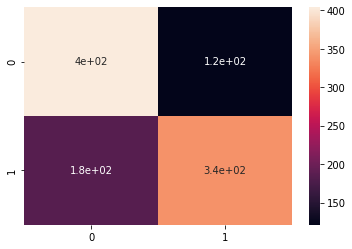

In [ ]:
sns.heatmap(cm, annot=True)

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

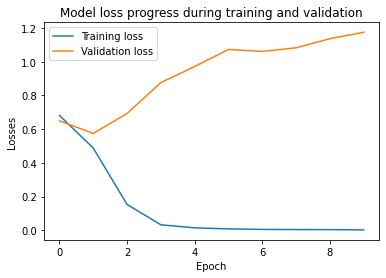

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend(['Training loss', 'Validation loss'])

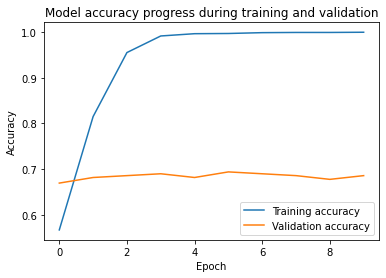

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])

## Previsões

In [ ]:
text = 'i hate you'
text = tokenizer.encode(text)
text

[8540, 8467, 5894, 2992, 8552]

In [ ]:
# 0 - negativo
# 1 - positivo

In [ ]:
Dcnn(np.array([text]), training=False).numpy()

array([[0.36709845]], dtype=float32)

# Conclusões Finais - CNN

No modelo apresentado, pode-se perceber que o treinamento obteve um bom desempenho, veja que à accuracy chegou a ** 0.7152**, ou sseja, um acerto de 71% da base de dados treinando 93% da base de dados utilizando apenas **10 epochs**. Já nossa ***Matriz de Confusão*** teve esses acertos:

  - classe 0 acertou 404, errou 121 registros
  - Classe 1 acertou 340, errou 185 registros

Assim, concluímos esse modelo de CNN em que houve um treinamento relativamente bem em relação aos dados de teste e treino di Twitter.

